In [22]:
!nvidia-smi

Thu Jun  4 15:58:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   37C    P8     8W / 250W |   2704MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   41C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Imports

In [21]:
import sys
import os
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from scipy.special import logsumexp
from scipy.io import arff

from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# from tensorboardX import SummaryWriter


from utils import kNN, AverageMeter, py_softmax

## Training parameters

In [2]:
!echo $PWD

/root/notebooks/Lunitsin/sl_rnn


In [23]:
#data
ds_path = "HandMovementDirection/HandMovementDirection"
datadir = "/root/data/Multivariate_ts"

label_enc = True
dims_num = 10
num_classes = 4
magic_dim = 25600

# optimization
lamb = 10      # SK lambda-parameter
nopts = 400    # number of SK-optimizations
epochs = 10   # numbers of epochs
momentum = 0.9 # sgd momentum
exp = './rnn_exp' # experiments results dir



# other
devc='1'  # cuda device
alr=0.03    #starting learning rate
epochs = 40
batch_size = 20
lr = 0.03
knn_dim = 4096
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [24]:
device = torch.device('cuda:' + devc) if torch.cuda.is_available() else torch.device('cpu')
print(f"GPU device: {device}")

GPU device: cuda:1


## Model parameters

In [10]:
hc=10       # number of heads
ncl=128     # number of clusters

numc = [ncl] * hc

## Data Preparation

In [19]:
def preproc(X, dims_num):
    X = X.applymap(np.array)
    cols_lst = X.columns
    
    for col_name in cols_lst:
        dimension_values = np.dstack(list(X[col_name].values))[0].T
        time_steps_num = dimension_values.shape[1]
        
        for i in range(time_steps_num):
            one_step_values = dimension_values[:, i]
            X[col_name + f'_{i}'] = one_step_values
    
    X = X.drop(columns=cols_lst)
    
    step = int(X.shape[1] / dims_num)
    X_3d = []
    init = 0
    for dim_num in range(dims_num):
        X_3d.append(X.iloc[:, init:init + step])
        init += step
    X_3d = np.dstack(X_3d)
    return X_3d

def load_file(filepath, dims_num, is_arff=False):
    if is_arff:
        data = arff.loadarff(filepath) 
        data = pd.DataFrame(data[0])
        X = data.iloc[:, :-1] # [30, 65] x 4 times
        y = data.iloc[:, -1]
        return X.values, y.values
    else:
        X, y = load_from_tsfile_to_dataframe(filepath)
        X = preproc(X, dims_num)
        return X, y

def load_group(prefix, filenames, dims_num, is_arff=False):
    loaded = []
    if is_arff:
        for name in filenames: 
            X, y = load_file(prefix + "/" + name, dims_num, is_arff=is_arff) # [30, 65]
            loaded.append(X)
            # stack group so that features are the 3rd dimension 
        loaded = np.dstack(loaded) # [30, 65, 4]
    else:
        loaded, y = load_file(prefix + "/" + filenames[0], dims_num, is_arff=is_arff) # [30, 65, 4]
    return loaded, y

def load_dataset_group(folder_path, ds_path, dims_num, is_train=True, label_enc=False, is_arff=False): 
    filenames = []
    extension = ".arff" if is_arff else ".ts"
    postfix = "_TRAIN" if is_train else "_TEST"
    
    if is_arff:
        for dim_num in range(1, dims_num + 1):
            filenames.append(ds_path + str(dim_num) + postfix + extension)
    else:
        filenames.append(ds_path + postfix + extension)

    X, y = load_group(folder_path, filenames, dims_num, is_arff=is_arff) # [30, 65, 4]
    X = torch.from_numpy(np.array(X, dtype=np.float64))
    if label_enc:
        le = preprocessing.LabelEncoder()
        y = le.fit_transform(y)
        y = torch.from_numpy(np.array(y, dtype=np.int32))
    else:
        y = torch.from_numpy(np.array(y, dtype=np.int32)) - 1
    X = X.transpose(1, 2)
    return X, y

def load_dataset(folder_path, ds_path, dims_num, label_enc=False, is_arff=False): 
    X_train, y_train = load_dataset_group(folder_path, ds_path, dims_num, 
                                          is_train=True, label_enc=label_enc, is_arff=is_arff) 
    X_test, y_test = load_dataset_group(folder_path, ds_path, dims_num, 
                                        is_train=False, label_enc=label_enc, is_arff=is_arff) 
    return X_train, y_train, X_test, y_test

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], excerpt

In [25]:
X_train, y_train, X_test, y_test = load_dataset(datadir, ds_path, dims_num, label_enc=label_enc, is_arff=False)
magic_dim_cnn = int(X_train.shape[2]/2)*10
print("X_train.shape:", X_train.shape, "\ny_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "\ny_test.shape:", y_test.shape)

X_train.shape: torch.Size([160, 10, 400]) 
y_train.shape: torch.Size([160])
X_test.shape: torch.Size([74, 10, 400]) 
y_test.shape: torch.Size([74])


## Model

In [26]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        out = self.fc(out[:, -1, :]) # Decode the hidden state of the last time step
        return out

In [10]:
def compute_accuracy(logits, y_true, device='cuda:0'):
    y_pred = torch.argmax(logits, dim=1)
    return (y_pred == y_true.to(device)).float().mean()

In [11]:
def train(model, num_epochs, batch_size, writer=None):
    train_loss = []
    train_accuracy = []
    
    for epoch in tqdm(range(num_epochs), desc='train', total=num_epochs):
        train_accuracy_batch = []
        train_loss_batch = []
        for i, (x_batch, labels, _) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
            x_batch = x_batch.to(device)
            labels = labels.to(device)

            predictions = model(x_batch.float())
            loss = criterion(predictions, labels.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if True:
                accuracy = compute_accuracy(predictions, labels, device=device)
                
                train_loss_batch.append(loss.item())
                train_accuracy_batch.append(accuracy.item())
                if writer:
                    writer.add_scalar('train/loss', loss.item(), global_step=len(train_loss))
            
        train_accuracy_overall = np.mean(train_accuracy_batch) * 100
        train_accuracy.append(train_accuracy_overall.item())
        
        train_loss_overall = np.mean(train_loss_batch)
        train_loss.append(train_loss_overall.item())
        if writer:
            writer.add_scalar('train/accuracy', train_accuracy_overall.item(), epoch + 1)
        
    return train_accuracy_overall, train_loss_overall, train_accuracy, train_loss

In [12]:
# %load_ext tensorboard

# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

In [13]:
def plot_loss_and_acc(loss, acc):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(loss)
    plt.grid(True)
    plt.title("Loss")
    plt.subplot(122)
    plt.plot(acc)
    plt.grid(True)
    plt.title("Accuracy, %");

### RNN train:

In [28]:
X_train.size(-1)

400

In [14]:
# Hyper-parameters
sequence_length = 28
input_size = X_train.size(-1)
hidden_size = 128
num_layers = 2

In [15]:
model_rnn = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr)

# exp_name = datetime.now().isoformat(timespec='seconds') + f'RNN'
# exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss = train(model_rnn, epochs, batch_size, writer=None)
train_accuracy_overall, train_loss_overall

train: 100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


(100.0, 0.00037488639645744115)

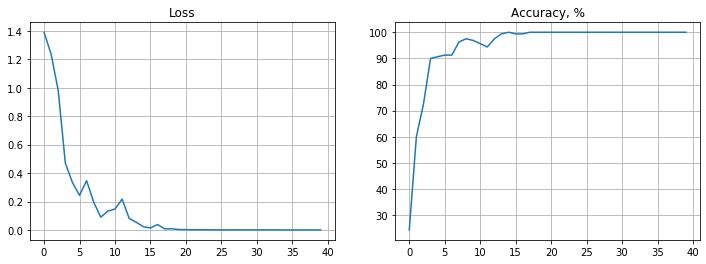

In [16]:
plot_loss_and_acc(train_loss, train_accuracy)

### CNN train

In [17]:
model_cnn = make_cnn(dims_num, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# exp_name = datetime.now().isoformat(timespec='seconds') + f'CNN'
# exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss = train(model_cnn, epochs, batch_size, writer=None)
train_accuracy_overall, train_loss_overall

train:   0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
train: 100%|██████████| 40/40 [00:01<00:00, 23.76it/s]


(25.000000558793545, 1.4936680793762207)

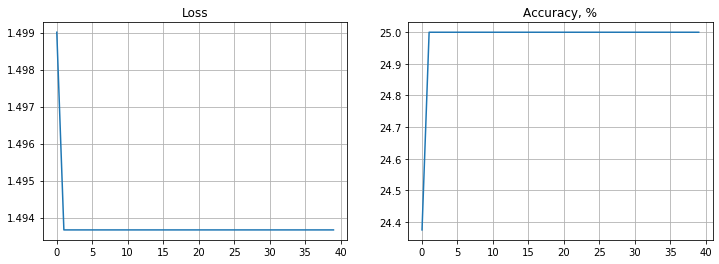

In [18]:
plot_loss_and_acc(train_loss, train_accuracy)

### ResNet

In [19]:
import torch.nn as nn
import math

__all__ = ['resnetv1','resnetv1_18']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, in_channel=3, width=1, num_classes=[1000]):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.headcount = len(num_classes)
        self.base = int(16 * width)
        self.features = nn.Sequential(*[                                                     # [100, 8, 18]
                            nn.Conv1d(in_channel, 16, kernel_size=3, padding=1, bias=False), # [100, 16, 36]
                            nn.BatchNorm1d(16),
                            nn.ReLU(inplace=True),
                            self._make_layer(block, self.base, layers[0]),                   # [100, 16, 36]
                            self._make_layer(block, self.base * 2, layers[1]),               # [100, 32, 36]
                            self._make_layer(block, self.base * 4, layers[2]),               # [100, 64, 36]
                            self._make_layer(block, self.base * 8, layers[3]),               # [100, 128, 36]
                            nn.AvgPool1d(2),                                                 # [100, 128, 18]
        ])
    
        if len(num_classes) == 1:
            self.top_layer = nn.Sequential(nn.Linear(magic_dim, num_classes[0]))
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(magic_dim, i))
            self.top_layer = None
        for m in self.features.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x.float())
        out = out.view(out.size(0), -1)
        if self.headcount == 1:
            if self.top_layer:
                out = self.top_layer(out)
            return out
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(out))
            return outp

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnetv1_18(num_classes=[1000]):
    """Encoder for instance discrimination and MoCo"""
    return resnet18(num_classes=num_classes)

In [20]:
hc=1       # number of heads
ncl=num_classes # number of clusters

numc = [ncl] * hc

In [21]:
model_resnet = resnet18(num_classes=numc, in_channel=dims_num).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=lr)

exp_name = datetime.now().isoformat(timespec='seconds') + f'ResNet'
exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss = train(model_resnet, epochs, batch_size, writer=None)
train_accuracy_overall, train_loss_overall

train: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


(100.0, 0.0003072083018196281)

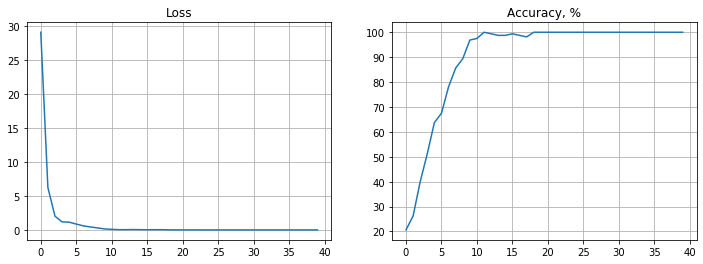

In [22]:
plot_loss_and_acc(train_loss, train_accuracy)

## Sinkhorn-Knopp optimization

In [11]:
def optimize_L_sk(PS):
    N, K = PS.shape
    tt = time.time()
    PS = PS.T  # now it is K x N
    r = np.ones((K, 1)) / K
    c = np.ones((N, 1)) / N
    PS **= lamb  # K x N
    inv_K = 1. / K
    inv_N = 1. / N
    err = 1e3
    _counter = 0
    while err > 1e-2:
        r = inv_K / (PS @ c)  # (KxN)@(N,1) = K x 1
        c_new = inv_N / (r.T @ PS).T  # ((1,K)@(KxN)).t() = N x 1
        if _counter % 10 == 0:
            err = np.nansum(np.abs(c / c_new - 1))
        c = c_new
        _counter += 1
    print("error: ", err, 'step ', _counter, flush=True)  # " nonneg: ", sum(I), flush=True)
    # inplace calculations.
    PS *= np.squeeze(c)
    PS = PS.T
    PS *= np.squeeze(r)
    PS = PS.T
    argmaxes = np.nanargmax(PS, 0)  # size N
    newL = torch.LongTensor(argmaxes)
    selflabels = newL.to(device)
    PS = PS.T
    PS /= np.squeeze(r)
    PS = PS.T
    PS /= np.squeeze(c)
    sol = PS[argmaxes, np.arange(N)]
    np.log(sol, sol)
    cost = -(1. / lamb) * np.nansum(sol) / N
    print('cost: ', cost, flush=True)
    print('opt took {0:.2f}min, {1:4d}iters'.format(((time.time() - tt) / 60.), _counter), flush=True)
    return cost, selflabels

def opt_sk(model, selflabels_in, epoch):
    if hc == 1:
        PS = np.zeros((len(trainloader.dataset), args.ncl))
    else:
        PS_pre = np.zeros((len(trainloader.dataset), knn_dim))
    for batch_idx, (data, _, _selected) in enumerate(trainloader):
        data = data.to(device)#cuda()
        if hc == 1:
            p = nn.functional.softmax(model(data), 1)
            PS[_selected, :] = p.detach().cpu().numpy()
        else:
            p = model(data)
            PS_pre[_selected, :] = p.detach().cpu().numpy()
    if hc == 1:
        cost, selflabels = optimize_L_sk(PS)
        _costs = [cost]
    else:
        _nmis = np.zeros(hc)
        _costs = np.zeros(hc)
        nh = epoch % hc  # np.random.randint(args.hc)
        print("computing head %s " % nh, end="\r", flush=True)
        tl = getattr(model, "top_layer%d" % nh)
        # do the forward pass:
        PS = (PS_pre @ tl.weight.cpu().numpy().T
                   + tl.bias.cpu().numpy())
        PS = py_softmax(PS, 1)
        c, selflabels_ = optimize_L_sk(PS)
        _costs[nh] = c
        selflabels_in[nh] = selflabels_
        selflabels = selflabels_in
    return selflabels


## Training utils

In [12]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = alr
    if epochs == 200:
        if epoch >= 80:
            lr = alr * (0.1 ** ((epoch - 80) // 40))  # i.e. 120, 160
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 400:
        if epoch >= 160:
            lr = alr * (0.1 ** ((epoch - 160) // 80))  # i.e. 240,320
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 800:
        if epoch >= 320:
            lr = alr * (0.1 ** ((epoch - 320) // 160))  # i.e. 480, 640
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 1600:
        if epoch >= 640:
            lr = alr * (0.1 ** ((epoch - 640) // 320))
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [13]:
def feature_return_switch(model, bool=True):
    """
    switch between network output or conv5features
        if True: changes switch s.t. forward pass returns post-conv5 features
        if False: changes switch s.t. forward will give full network output
    """
    if bool:
        model.headcount = 1
    else:
        model.headcount = hc
    model.return_feature = bool

In [14]:
def train(epoch, selflabels):
    print('\nEpoch: %d' % epoch)
    print(name)
    adjust_learning_rate(optimizer, epoch)
    train_loss = AverageMeter()
    data_time = AverageMeter()
    batch_time = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    for batch_idx, (inputs, targets, indexes) in enumerate(trainloader):
        niter = epoch * len(trainloader) + batch_idx
        if niter * trainloader.batch_size >= optimize_times[-1]:
            with torch.no_grad():
                _ = optimize_times.pop()
                if hc >1:
                    feature_return_switch(model, True)
                selflabels = opt_sk(model, selflabels, epoch)
                if hc >1:
                    feature_return_switch(model, False)
        data_time.update(time.time() - end)
        inputs, targets, indexes = inputs.to(device), targets.to(device), indexes.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        if hc == 1:
            loss = criterion(outputs, selflabels[indexes])
        else:
            loss = torch.mean(torch.stack([criterion(outputs[h],
                                                     selflabels[h, indexes]) for h in range(hc)]))

        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % 10 == 0:
            print('Epoch: [{}][{}/{}]'
                  'Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) '
                  'Data: {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Loss: {train_loss.val:.4f} ({train_loss.avg:.4f})'.format(
                epoch, batch_idx, len(trainloader), batch_time=batch_time, data_time=data_time, train_loss=train_loss))
            writer.add_scalar("loss", loss.item(), batch_idx*512 +epoch*len(trainloader.dataset))
    return selflabels

## Model initialization

In [15]:
model = alexnet(num_classes=numc)

In [16]:
optimize_times = ((epochs + 1.0001)*N*(np.linspace(0, 1, nopts))[::-1]).tolist()
optimize_times = [(epochs +10)*N] + optimize_times
print('We will optimize L at epochs:', [np.round(1.0*t/N, 2) for t in optimize_times], flush=True)

We will optimize L at epochs: [410.0, 401.0, 400.0, 398.99, 397.99, 396.98, 395.98, 394.97, 393.97, 392.96, 391.95, 390.95, 389.94, 388.94, 387.93, 386.93, 385.92, 384.92, 383.91, 382.91, 381.9, 380.9, 379.89, 378.89, 377.88, 376.88, 375.87, 374.87, 373.86, 372.86, 371.85, 370.85, 369.84, 368.84, 367.83, 366.83, 365.82, 364.82, 363.81, 362.81, 361.8, 360.8, 359.79, 358.79, 357.78, 356.78, 355.77, 354.77, 353.76, 352.76, 351.75, 350.75, 349.74, 348.74, 347.73, 346.73, 345.72, 344.72, 343.71, 342.71, 341.7, 340.7, 339.69, 338.69, 337.68, 336.68, 335.67, 334.67, 333.66, 332.66, 331.65, 330.65, 329.64, 328.64, 327.63, 326.63, 325.62, 324.62, 323.61, 322.61, 321.6, 320.6, 319.59, 318.59, 317.58, 316.58, 315.57, 314.57, 313.56, 312.56, 311.55, 310.55, 309.54, 308.54, 307.53, 306.53, 305.52, 304.52, 303.51, 302.51, 301.5, 300.5, 299.49, 298.49, 297.48, 296.48, 295.47, 294.47, 293.46, 292.46, 291.45, 290.45, 289.44, 288.44, 287.43, 286.43, 285.42, 284.42, 283.41, 282.41, 281.4, 280.4, 279.39, 

In [17]:
# init selflabels randomly
if hc == 1:
    selflabels = np.zeros(N, dtype=np.int32)
    for qq in range(N):
        selflabels[qq] = qq % ncl
    selflabels = np.random.permutation(selflabels)
    selflabels = torch.LongTensor(selflabels).to(device)
else:
    selflabels = np.zeros((hc, N), dtype=np.int32)
    for nh in range(hc):
        for _i in range(N):
            selflabels[nh, _i] = _i % numc[nh]
        selflabels[nh] = np.random.permutation(selflabels[nh])
    selflabels = torch.LongTensor(selflabels).to(device)

In [18]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)
model.to(device)
criterion = nn.CrossEntropyLoss()

In [19]:
name = "AlexNetfromthepaper"
writer = SummaryWriter(f'./runs/cifar10/{name}')

## Training! 
Takes a couple of minutes per epoch

In [ ]:
for epoch in range(start_epoch, start_epoch + epochs):
    selflabels = train(epoch, selflabels)
    feature_return_switch(model, True)
    acc = kNN(model, trainloader, testloader, K=10, sigma=0.1, dim=knn_dim)
    feature_return_switch(model, False)
    writer.add_scalar("accuracy kNN", acc, epoch)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'opt': optimizer.state_dict(),
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/best_ckpt.t7' % (exp))
        best_acc = acc
    if epoch % 100 == 0:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'opt': optimizer.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/ep%s.t7' % (exp, epoch))
    if epoch % 50 == 0:
        feature_return_switch(model, True)
        acc = kNN(model, trainloader, testloader, K=[50, 10],
                  sigma=[0.1, 0.5], dim=knn_dim, use_pca=True)
        i = 0
        for num_nn in [50, 10]:
            for sig in [0.1, 0.5]:
                writer.add_scalar('knn%s-%s' % (num_nn, sig), acc[i], epoch)
                i += 1
        feature_return_switch(model, False)
    print('best accuracy: {:.2f}'.format(best_acc * 100))

checkpoint = torch.load('%s'%exp+'/best_ckpt.t7' )
model.load_state_dict(checkpoint['net'])
feature_return_switch(model, True)
acc = kNN(model, trainloader, testloader, K=10, sigma=0.1, dim=knn_dim, use_pca=True)


Epoch: 0
AlexNetfromthepaper
error:  0.003979012589635067 step  31
cost:  4.0347929817170884
opt took 0.01min,   31iters
Epoch: [0][0/391]Time: 63.655 (63.655) Data: 63.556 (63.556) Loss: 4.9827 (4.9827)
Epoch: [0][10/391]Time: 0.122 (5.895) Data: 0.017 (5.792) Loss: 4.9202 (4.9415)
Epoch: [0][20/391]Time: 0.123 (3.146) Data: 0.018 (3.043) Loss: 4.9069 (4.9248)
Epoch: [0][30/391]Time: 0.125 (2.177) Data: 0.021 (2.073) Loss: 4.8777 (4.9112)
Epoch: [0][40/391]Time: 0.124 (1.687) Data: 0.019 (1.583) Loss: 4.8658 (4.9020)
Epoch: [0][50/391]Time: 0.289 (1.393) Data: 0.186 (1.289) Loss: 4.8722 (4.8953)
Epoch: [0][60/391]Time: 0.121 (1.193) Data: 0.016 (1.088) Loss: 4.8640 (4.8903)
Epoch: [0][70/391]Time: 0.120 (1.052) Data: 0.016 (0.948) Loss: 4.8634 (4.8867)
Epoch: [0][80/391]Time: 0.120 (0.942) Data: 0.018 (0.838) Loss: 4.8623 (4.8838)
Epoch: [0][90/391]Time: 0.332 (0.860) Data: 0.230 (0.756) Loss: 4.8681 (4.8813)
Epoch: [0][100/391]Time: 0.119 (0.789) Data: 0.016 (0.686) Loss: 4.8623 (4.

Epoch: [2][140/391]Time: 0.111 (0.562) Data: 0.010 (0.459) Loss: 4.8326 (4.8483)
Epoch: [2][150/391]Time: 0.307 (0.534) Data: 0.201 (0.432) Loss: 4.8446 (4.8482)
Epoch: [2][160/391]Time: 0.112 (0.511) Data: 0.011 (0.409) Loss: 4.8386 (4.8480)
Epoch: [2][170/391]Time: 0.113 (0.490) Data: 0.011 (0.388) Loss: 4.8491 (4.8479)
Epoch: [2][180/391]Time: 0.116 (0.472) Data: 0.014 (0.369) Loss: 4.8436 (4.8479)
Epoch: [2][190/391]Time: 0.202 (0.454) Data: 0.098 (0.351) Loss: 4.8447 (4.8479)
Epoch: [2][200/391]Time: 0.113 (0.437) Data: 0.011 (0.335) Loss: 4.8428 (4.8478)
Epoch: [2][210/391]Time: 0.113 (0.422) Data: 0.011 (0.320) Loss: 4.8465 (4.8477)
Epoch: [2][220/391]Time: 0.115 (0.409) Data: 0.012 (0.307) Loss: 4.8430 (4.8477)
Epoch: [2][230/391]Time: 0.313 (0.400) Data: 0.210 (0.297) Loss: 4.8456 (4.8476)
Epoch: [2][240/391]Time: 0.122 (0.389) Data: 0.017 (0.287) Loss: 4.8499 (4.8475)
Epoch: [2][250/391]Time: 0.112 (0.380) Data: 0.011 (0.277) Loss: 4.8453 (4.8475)
Epoch: [2][260/391]Time: 0.1